## Transformer-tensorflow 1

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import jieba
import codecs
import collections
import sys
from operator import itemgetter
import tqdm

import time
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib.font_manager import FontProperties

In [2]:
DIR_PATH="/home/xujingzhou/en-zh"
# font_set = FontProperties(fname=r"c:/windows/fonts/微软雅黑.ttc", size=15)
BUFFER_SIZE = 20000
BATCH_SIZE = 64
MAX_LENGTH = 40

In [3]:
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.load_from_file(DIR_PATH+'/en')
tokenizer_zh = tfds.deprecated.text.SubwordTextEncoder.load_from_file(DIR_PATH+'/zh')

def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # 将 sin 应用于数组中的偶数索引（indices）；2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # 将 cos 应用于数组中的奇数索引；2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # 添加额外的维度来将填充加到
  # 注意力对数（logits）。
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

def scaled_dot_product_attention(q, k, v, mask):
  """计算注意力权重。
  q, k, v 必须具有匹配的前置维度。
  k, v 必须有匹配的倒数第二个维度，例如：seq_len_k = seq_len_v。
  虽然 mask 根据其类型（填充或前瞻）有不同的形状，
  但是 mask 必须能进行广播转换以便求和。
  
  参数:
    q: 请求的形状 == (..., seq_len_q, depth)
    k: 主键的形状 == (..., seq_len_k, depth)
    v: 数值的形状 == (..., seq_len_v, depth_v)
    mask: Float 张量，其形状能转换成
          (..., seq_len_q, seq_len_k)。默认为None。
    
  返回值:
    输出，注意力权重
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # 缩放 matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # 将 mask 加入到缩放的张量上。
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax 在最后一个轴（seq_len_k）上归一化，因此分数
  # 相加等于1。
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [4]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """分拆最后一个维度到 (num_heads, depth).
    转置结果使得形状为 (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # 将嵌入和位置编码相加。
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_en.vocab_size + 2
target_vocab_size = tokenizer_zh.vocab_size + 2
dropout_rate = 0.1

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

def create_masks(inp, tar):
  # 编码器填充遮挡
  enc_padding_mask = create_padding_mask(inp)
  
  # 在解码器的第二个注意力模块使用。
  # 该填充遮挡用于遮挡编码器的输出。
  dec_padding_mask = create_padding_mask(inp)
  
  # 在解码器的第一个注意力模块使用。
  # 用于填充（pad）和遮挡（mask）解码器获取到的输入的后续标记（future tokens）。
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [5]:
checkpoint_path = "/home/xujingzhou/checkpoint3/"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果检查点存在，则恢复最新的检查点。
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [6]:
# 该 @tf.function 将追踪-编译 train_step 到 TF 图中，以便更快地
# 执行。该函数专用于参数张量的精确形状。为了避免由于可变序列长度或可变
# 批次大小（最后一批次较小）导致的再追踪，使用 input_signature 指定
# 更多的通用形状。

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [7]:
#en和zh弄反了呜呜呜呜呜呜呜呜呜呜呜！！
def evaluate(inp_sentence):
  start_token = [tokenizer_en.vocab_size]
  end_token = [tokenizer_en.vocab_size + 1]
  
  # 输入语句是葡萄牙语，增加开始和结束标记
  inp_sentence = start_token + tokenizer_en.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # 因为目标是英语，输入 transformer 的第一个词应该是
  # 英语的开始标记。
  decoder_input = [tokenizer_zh.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # 从 seq_len 维度选择最后一个词
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # 如果 predicted_id 等于结束标记，就返回结果
    if predicted_id == tokenizer_zh.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # 连接 predicted_id 与输出，作为解码器的输入传递到解码器。
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_en.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # 画出注意力权重
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    # fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)-1))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_en.decode([i]) for i in sentence]+['<end>'], 
        rotation=90)
    
    ax.set_yticklabels([tokenizer_zh.decode([i]) for i in result 
                        if i < tokenizer_zh.vocab_size])
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

def translate(sentence, plot=''):
  # sentence=sentence.strip()#训练的时候没有转小写。。。寄
  #转小写
  # sentence = sentence.lower()
  result, attention_weights = evaluate(sentence)
  # print(result)
  predicted_sentence = tokenizer_zh.decode([i for i in result 
                                            if i < tokenizer_zh.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

In [8]:
translate('i am very happy,because this is my first time to get a good result. ')

Input: i am very happy,because this is my first time to get a good result. 
Predicted translation: 我非常感到满意,因为这是我首次取得良好成果的第一次.



Input: this model also seems to work well on complex sentence.
Predicted translation: 这一模型似乎也在复杂的判决方面开展良好工作.



/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 36825 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 19968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 27169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 22411 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 20284 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 20046 missing from current font.
  font.set_

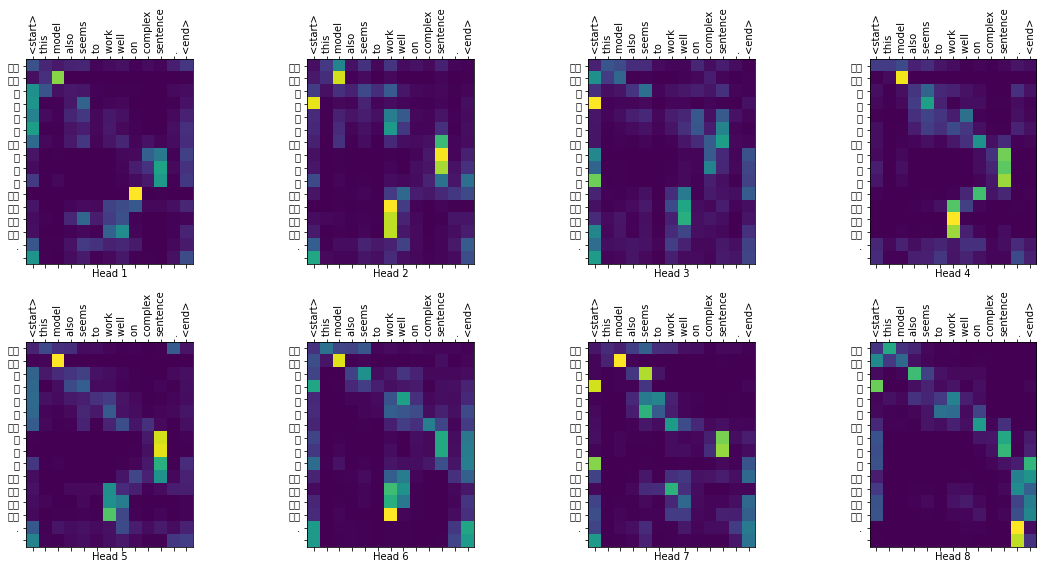

In [9]:
translate('this model also seems to work well on complex sentence.',plot='decoder_layer3_block2')

In [10]:
translate("today I want to eat a lot of food.")

Input: today I want to eat a lot of food.
Predicted translation: 目前,PDAPS希望食食物大量.



In [11]:
translate("hello world.")

Input: hello world.
Predicted translation: Heio世界.



In [15]:
input_vocab_size

32532

# 模型评估——计算BLEU

In [12]:
def BLEU_score(translate):
    from nltk.translate.bleu_score import sentence_bleu,SmoothingFunction
    import codecs
    zh_predict=''
    zh_real=''
    with codecs.open('/home/xujingzhou/en-zh/test.zh', 'r', 'utf-8') as f:
        for line in f:
            zh_real=zh_real+line
    with codecs.open('/home/xujingzhou/en-zh/test.en', 'r', 'utf-8') as f:
        i=0
        for line in f:
            line_pre=translate(line)
            zh_predict=zh_predict+line_pre
            i+=1
            if(i%100==0):
                print("translate "+str(i)+"00/4000")
    #先尝试一种计算BLEU的方法
    return zh_real,zh_predict

In [13]:
def translate_code(sentence):
    # sentence=sentence.strip()#训练的时候没有转小写。。。寄
    #转小写
    # sentence = sentence.lower()
    result, attention_weights = evaluate(sentence)
    return result

In [14]:
def zh_encoder(sentence):
    return sentence